# Load Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnm
import glob
import h5py
from scipy.linalg import lstsq
from matplotlib.colors import LogNorm
from numpy.fft import *

# Load radial profile and data

prograde modes

In [2]:
a = 0.5

In [3]:
rs_radial_pro = []
radial_wf_pro = []
omegas_pro = []
radial_coeff_pro = []

file = h5py.File("../data/qnm/a0.5_l2_m2.h5",'r')
for i in range(4):
    rs_radial_pro.append(np.array(file['[n=%s]'%i]['rvals']))
    radial_wf_pro.append(np.array(file['[n=%s]'%i]['radial_func']))
    radial_coeff_pro.append(np.array(file['[n=%s]'%i]['radial_coef']))
    omegas_pro.append(np.array(file['[n=%s]'%i]['omega']))

In [4]:
rs_radial_32pro = []
radial_wf_32pro = []
omegas_32pro = []
radial_coeff_32pro = []

file = h5py.File("../data/qnm/a0.5_l3_m2.h5",'r')
for i in range(2):
    rs_radial_32pro.append(np.array(file['[n=%s]'%i]['rvals']))
    radial_wf_32pro.append(np.array(file['[n=%s]'%i]['radial_func']))
    radial_coeff_32pro.append(np.array(file['[n=%s]'%i]['radial_coef']))
    omegas_32pro.append(np.array(file['[n=%s]'%i]['omega']))

retrograde modes

In [5]:
rs_radial_retro = []
radial_wf_retro = []
omegas_retro = []
radial_coeff_retro = []
file = h5py.File("../data/qnm/a0.5_l2_m-2.h5",'r')

for i in range(4):
    rs_radial_retro.append(np.array(file['[n=%s]'%i]['rvals']))
    radial_wf_retro.append(np.conjugate(np.array(file['[n=%s]'%i]['radial_func'])))
    radial_coeff_retro.append(np.array(file['[n=%s]'%i]['radial_coef']))
    omegas_retro.append(-np.conjugate(np.array(file['[n=%s]'%i]['omega'])))

In [6]:
omegas_pro = np.array(omegas_pro)
omegas_retro = np.array(omegas_retro)

In [8]:
# Interpolation functions for radial quasinormal eigenfunctions
rmax = (1 / (a**2)) * (1 - np.sqrt(1 - ((a)**2)))
wf_pro = []
wf_retro = []
for i in range(4):
    wf_pro.append(np.polynomial.chebyshev.Chebyshev(radial_coeff_pro[i]/radial_wf_pro[i][-1],domain=[0,rmax]))
    wf_retro.append(np.polynomial.chebyshev.Chebyshev(radial_coeff_retro[i]/radial_wf_retro[i][-1],domain=[0,rmax]))

## Scattering data from the TeukEvolution.jl

In [12]:
files = glob.glob("../data/TeukEvolution/a0.5_scattering/scattering_a0.5_nx256_ny28.npz")

psi4_l = np.load(files[0])['psi4_l']
dt_psi4_l = np.load(files[0])['dt_psi4_l']
t = np.load(files[0])['time']
r = np.load(files[0])['rads']

In [13]:
# The two-dimensional domain of data
R, T = np.meshgrid(r, t)
nr, nt = r.shape[0], t.shape[0]

In [15]:
# use only the l=2 component
Z = np.nan_to_num(psi4_l[0])
dZ = np.nan_to_num(dt_psi4_l[0])

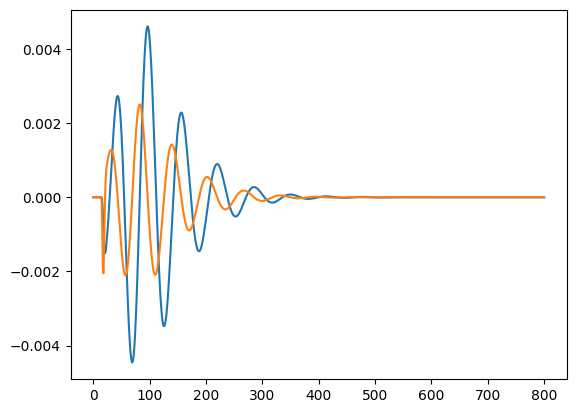

In [16]:
plt.plot(Z[:,0].real)
plt.plot(dZ[:,0].real)

# Fit with only time

How precise can one fit the signal at a single fixed radius given the time series for $\psi_4$?

This is close to what we experimentally measure.

Here, we fit prograde and retrograde modes simutaneously

In [17]:
def qnm_22_pro_t(t, A, n):
    return A*np.exp(-1j*(omegas_pro[int(n)]*t))
def qnm_22_retro_t(t, A, n):
    return A*np.exp(-1j*(omegas_retro[int(n)]*t))

In [18]:
def time_only_fit(Z,t,t0,modes):
    """
    Z: 1 dimensional time series signal to fit
    t: the time cooridnate
    t0: start time of the fit, before which the signal is ignored
    modes: which modes to fit? overtone labels [0,1,2,...]
    """
    M = np.zeros((t[t>=t0].shape[0],2*len(modes)),dtype='complex128')

    for m in modes:
        # prograde modes
        M[:,m] = qnm_22_pro_t(t[t>=t0], 1, m).ravel()
        # retrograde modes
        M[:,len(modes)+m] = qnm_22_retro_t(t[t>=t0], 1, m).ravel()
    x,residual,rank,s = lstsq(M,Z[t>=t0].ravel())
    residual = np.mean(np.abs(np.dot(M,x)-Z[t>=t0].ravel()))
    return x,residual

In [19]:
def reconstruct_signal(t,x,modes):
    sig = np.zeros(t.shape[0], dtype='complex128')
    for m in modes:
        # prograde
        sig += qnm_22_pro_t(t,x[m],m)
        # retrograde
        sig += qnm_22_retro_t(t,x[len(modes)+m],m)
    return sig

In [20]:
# only fit the prograde and retrograde fundamentals
modes = range(1)

# Fit the signal in time at each radius
pro = True
xs_t = []
residuals = []
for i in range(Z.shape[1]):
    x,residual = time_only_fit(Z[:,i],t,50,modes)
    xs_t.append(x)
    residuals.append(residual)
xs_t = np.array(xs_t)
residuals = np.array(residuals)

In [21]:
# Fit the signal in time at each radius
pro = True
xs_t2 = []
residuals = []
for i in range(dZ.shape[1]):
    x,residual = time_only_fit(dZ[:,i],t,50,modes)
    xs_t2.append(x)
    residuals.append(residual)
xs_t2 = np.array(xs_t2)
residuals = np.array(residuals)

We see that the residual is mostly dominated by (3,2,0) mode

(1e-12, 0.1)

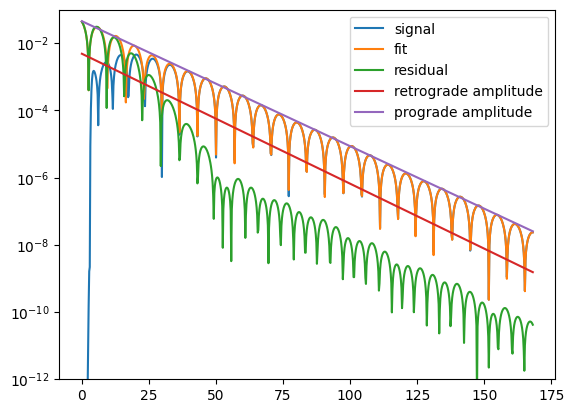

In [22]:
ind = 0
plt.plot(t,np.abs(Z[:,ind].real),label='signal')
#plt.plot(t,np.abs(qnm_22_pro(t, xs[ind,1], 1)))

plt.plot(t,np.abs(reconstruct_signal(t,xs_t[ind],modes).real),label='fit')
plt.plot(t,np.abs(Z[:,ind].real-reconstruct_signal(t,xs_t[ind],modes).real),label='residual')
plt.plot(t,np.abs(qnm_22_retro_t(t, xs_t[ind][1], 0)),label='retrograde amplitude')
plt.plot(t,np.abs(qnm_22_pro_t(t, xs_t[ind][0], 0)),label='prograde amplitude')

plt.yscale('log')
plt.legend()
plt.ylim(1e-12,1e-1)

How much radial coherence can we recover?

Text(0.5, 1.0, 'Fundamental Prograde Mode')

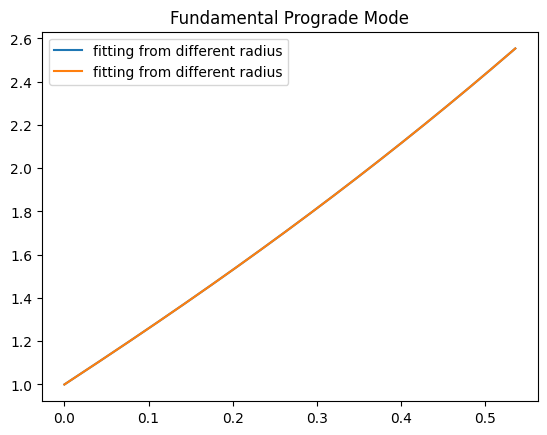

In [23]:
m = 0
#$plt.plot(rs_radial_pro[m],np.abs(radial_wf_pro[m]/),label='radial eigenfunction')
plt.plot(r,np.abs(xs_t[:,m]/xs_t[:,m][0]),label='fitting from different radius')

plt.plot(r,np.abs(xs_t[:,m]/xs_t[:,m][0]),label='fitting from different radius')
plt.legend()
plt.title("Fundamental Prograde Mode")
# Series corruption occurs

Text(0.5, 1.0, 'Fundamental Retrograde Mode')

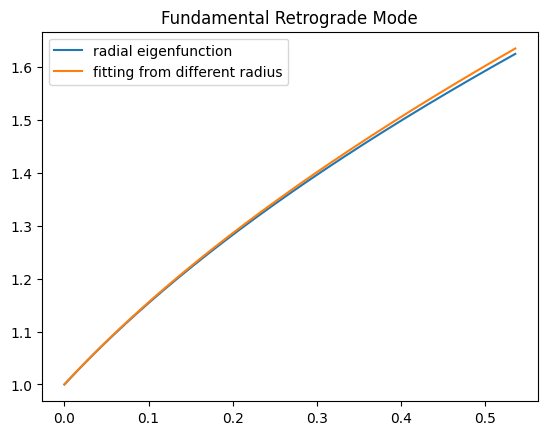

In [24]:
m = 0
plt.plot(rs_radial_retro[m],np.abs(radial_wf_retro[m]/radial_wf_retro[m][-1]),label='radial eigenfunction')

plt.plot(r,np.abs(xs_t[:,len(modes)+m]/xs_t[:,len(modes)+m][0]),label='fitting from different radius')
plt.legend()
plt.title("Fundamental Retrograde Mode")
# Series corruption occurs

We note that both the prograde and retrograde radial eigenfunctions are recovered!

# Excitation Amplitude and Fitting with Radial Eigenfunctions

## Excitation Matrix construction

In [25]:
def design_matrix(r,modes):
    M = np.zeros((r.shape[0]*2,len(modes)*2),dtype='complex128')
    for m in modes:
        # prograde wavefunction and time derivative
        M[:r.shape[0],m] = wf_pro[m](r)
        M[r.shape[0]:,m] = -1j*wf_pro[m](r)*omegas_pro[m]
        # retrograde wavefunction and time derivative
        M[:r.shape[0],len(modes)+m] = wf_retro[m](r)
        M[r.shape[0]:,len(modes)+m] = -1j*wf_retro[m](r)*omegas_retro[m]
    return M

In [26]:
def qnm_22_pro(r, t, A, m):
    return (np.outer(A*np.exp(-1j*(omegas_pro[m]*t)),wf_pro[m](r)/wf_pro[m](0)))
def qnm_22_retro(r, t, A, m):
    return (np.outer(A*np.exp(-1j*(omegas_retro[m]*t)),wf_retro[m](r)/wf_retro[m](0)))
def qnm_32_pro(r, t, A, m):
    return (np.outer(A*np.exp(-1j*(omegas_32pro[m]*t)),wf_32pro[m](r)/wf_32pro[m](0)))

In [27]:
# Construct rhs
bs = []
for i in range(t.shape[0]): 
    bs.append(np.append(Z[i],dZ[i]))
bs = np.array(bs)

In [37]:
# Construct design matrix with 3 prograde modes 
# and 3 retrograde modes
modes2 = range(3)
M = design_matrix(r,modes2)
Minv = np.linalg.pinv(M)

In [38]:
# Compute excitation factors

ext_xs = []
for i in range(t.shape[0]):
    x = np.dot(Minv,bs[i])
    ext_xs.append(x)
ext_xs = np.array(ext_xs)

In [39]:
# time where the amplitude of psi4 peaks at null infinity 
# and at horizon
tmax = t[np.abs(Z[:,0])==np.abs(Z[:,0]).max()][0]
tmax_horizon = t[np.abs(Z[:,-1])==np.abs(Z[:,-1]).max()][0]

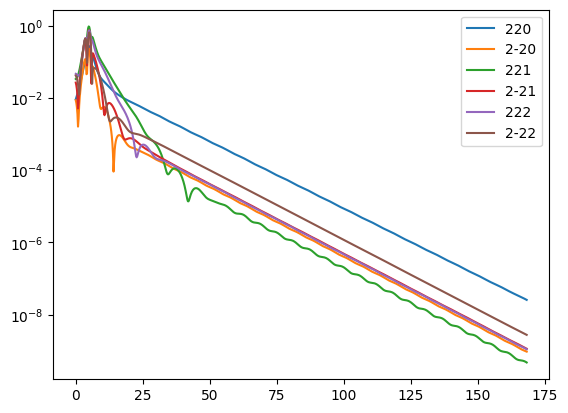

In [40]:
for m in modes2:
    plt.plot(t,np.abs(ext_xs[:,m]),label='22%s'%m)#*np.exp(1j*omegas_pro[m]*(t-tmax))),label='22%s'%m)
    plt.plot(t,np.abs(ext_xs[:,len(modes2)+m]),label='2-2%s'%m)

    #plt.plot(t,np.abs(xs[:,m+len(modes)]*np.exp(1j*omegas_retro[m]*(t-tmax))),label='22%s retrograde'%m)

    plt.yscale('log')
#plt.xlim(0,60)
#plt.ylim(1e-5,1e2)
plt.legend()

# Fitting

In [41]:
def construct_matrix_and_fit(Z,r,t,t0,modes):
    M = np.zeros((t[t>=t0].shape[0]*r.shape[0],2*len(modes)),dtype='complex128')
    R, T = np.meshgrid(r, t)
    for m in modes:
        M[:,m] = qnm_22_pro(r, t[t>=t0], 1, m).ravel()
        M[:,len(modes)+m] = qnm_22_retro(r, t[t>=t0], 1, m).ravel()
    x,residual,rank,s = lstsq(M,Z[T>=t0].ravel())
    residual = np.mean(np.abs(np.dot(M,x)-Z[T>=t0].ravel()))
    return x,residual

In [42]:
fit_xs = []
fit_residuals = []
for t0 in t:
    x,residual = construct_matrix_and_fit(Z,r,t,t0,modes2)
    fit_xs.append(x)
    fit_residuals.append(residual)
fit_xs = np.array(fit_xs)

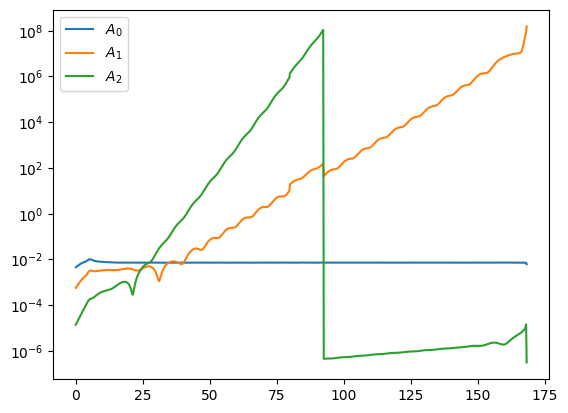

In [43]:
for m in modes2:
    plt.plot(t,np.abs(fit_xs[:,m]*np.exp(1j*omegas_pro[m]*(-tmax))),label='$A_{%s}$'%m)
plt.legend()
plt.yscale('log')
#plt.ylim(1e-5,1)
#plt.xlim(0,30)

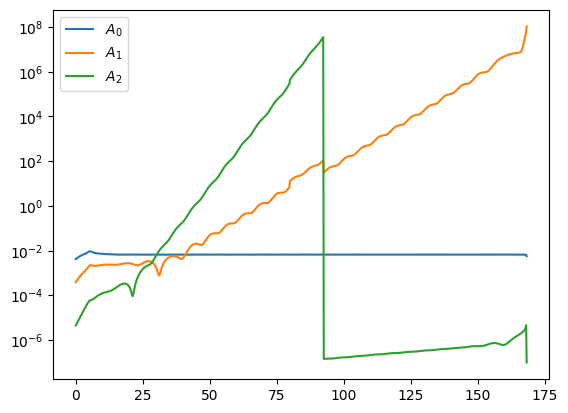

In [44]:
for m in modes2:
    plt.plot(t,np.abs(fit_xs[:,m]*np.exp(1j*omegas_retro[m]*(-tmax))),label='$A_{%s}$'%m)
plt.legend()
plt.yscale('log')
#plt.ylim(1e-5,1)
#plt.xlim(0,30)

Text(0.5, 1.0, 'prograde modes')

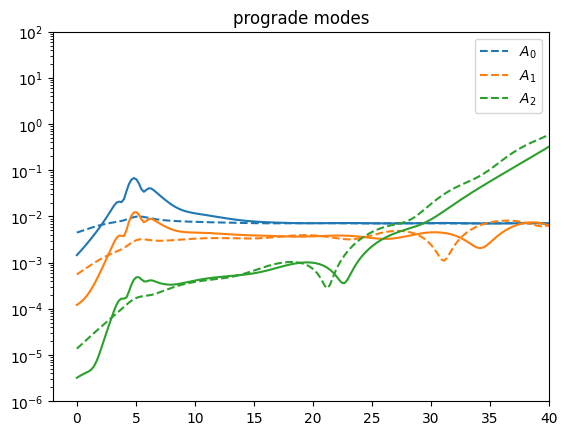

In [47]:
# Dashed lines are from fitting and the solid lines 
# are from the excitation factor calculation. 
# They agree perfectly!
for m in modes2:
    plt.plot(t,np.abs(fit_xs[:,m]*np.exp(1j*omegas_pro[m]*(-tmax))),'--',label='$A_{%s}$'%m)
    plt.plot(t,np.abs(ext_xs[:,m]*np.exp(1j*omegas_pro[m]*(t-tmax))),c='C%s'%m)
plt.yscale('log')
plt.xlim(-2,40)
plt.ylim(1e-6,1e2)
plt.legend()
plt.title("prograde modes")

Text(0.5, 1.0, 'retrograde modes')

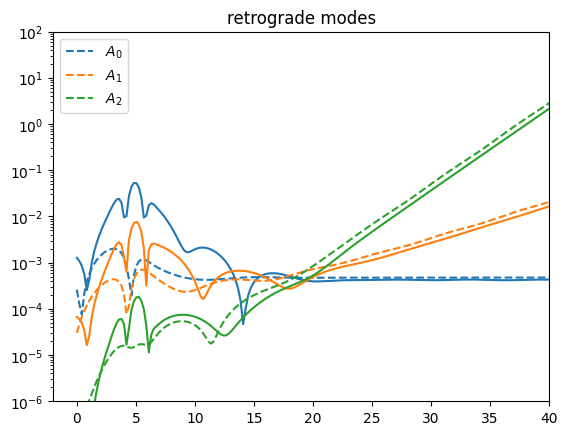

In [48]:
# Dashed lines are from fitting and the solid lines 
# are from the excitation factor calculation. 
# They agree perfectly!
for m in modes2:
    plt.plot(t,np.abs(fit_xs[:,len(modes2)+m]*np.exp(1j*omegas_retro[m]*(-tmax))),'--',label='$A_{%s}$'%m)
    plt.plot(t,np.abs(ext_xs[:,len(modes2)+m]*np.exp(1j*omegas_retro[m]*(t-tmax))),c='C%s'%m)
plt.yscale('log')
plt.xlim(-2,40)
plt.ylim(1e-6,1e2)
plt.legend()
plt.title("retrograde modes")